In [12]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost with Mean Encodings of all Hierarchical Levels
Include all levels of encodings.  This is an additional baseline for hierarchical or target-mean encoding.

*This script takes about 5 minutes on my MacBook Air*

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [14]:
from pathlib import Path

In [15]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [16]:
from sba_gnn.sba_gnn import sg_plot

## Import Processed Datasets

In [17]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [19]:
train_df = sba_loans[sba_loans['dset'] == 'train']
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

#### Set the predictor features.  Inlcude the mean-encoded NAICS

In [20]:
predictor_features = setup.predictor_features + \
    ['menc_NAICS', 'menc_NAICS_5', 'menc_NAICS_4', 'menc_NAICS_3', 'menc_NAICS_sector']
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'menc_NAICS', 'menc_NAICS_5', 'menc_NAICS_4', 'menc_NAICS_3', 'menc_NAICS_sector']


In [55]:
with open(Path(setup.temp_path).joinpath('A01_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [23]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [24]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [25]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [26]:
xgb_model = xgb_model.set_params(**xgb_params)

In [27]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50022	validation_1-logloss:0.50377
[1]	validation_0-logloss:0.49261	validation_1-logloss:0.49640
[2]	validation_0-logloss:0.48618	validation_1-logloss:0.49023
[3]	validation_0-logloss:0.48075	validation_1-logloss:0.48499
[4]	validation_0-logloss:0.47619	validation_1-logloss:0.48064
[5]	validation_0-logloss:0.47227	validation_1-logloss:0.47690
[6]	validation_0-logloss:0.46890	validation_1-logloss:0.47366
[7]	validation_0-logloss:0.46602	validation_1-logloss:0.47093
[8]	validation_0-logloss:0.46350	validation_1-logloss:0.46859
[9]	validation_0-logloss:0.46132	validation_1-logloss:0.46656
[10]	validation_0-logloss:0.45937	validation_1-logloss:0.46476
[11]	validation_0-logloss:0.45776	validation_1-logloss:0.46328
[12]	validation_0-logloss:0.45636	validation_1-logloss:0.46201
[13]	validation_0-logloss:0.45517	validation_1-logloss:0.46098
[14]	validation_0-logloss:0.45409	validation_1-logloss:0.46000
[15]	validation_0-logloss:0.45308	validation_1-logloss:0.45910
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
train_df['target'].value_counts()

target
0    346866
1     89254
Name: count, dtype: int64

##### Save the model

In [29]:
xgb_model.save_model(Path(setup.temp_path).joinpath('A01_MODEL_xgboost.json'))

In [30]:
with open(Path(setup.temp_path).joinpath('A01_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [31]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [32]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.184700,0.114491,0.015744,0.680819,0.170971
1,0.284712,0.110051,0.016498,0.681501,0.286764


## Decision Threshold
Max f1, on training data

In [33]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [34]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [35]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('A01_REPORT_thresh_tune.csv'), index=False)

In [36]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.457966
11,0.22,0.456154


##### Apply decision threshold
All datasets

In [37]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [38]:
pred_df['predict_bin'].value_counts()

predict_bin
0    403585
1    284496
Name: count, dtype: int64

In [39]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A01_DATA_combined_predictions.parquet'))

## Metrics

In [40]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('A01_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.659214,0.440302,0.324545,0.684416,0.371854,0.730723,NaN
1,train,0.664849,0.457966,0.342269,0.691823,0.396499,0.738269,NaN
2,val,0.659801,0.451949,0.339427,0.676070,0.388941,0.728978,NaN
0,test,0.659119,0.451451,0.337409,0.681944,0.386990,0.730515,0.0
1,test,0.659349,0.423457,0.305767,0.688436,0.354598,0.732690,1.0


## Lift
Test data

In [41]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

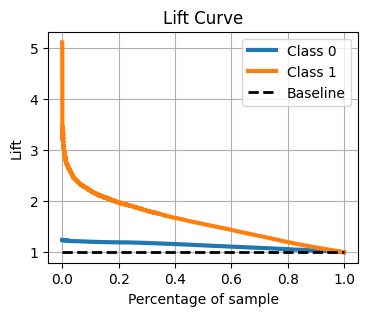

In [42]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A01_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [43]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [44]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('A01_REPORT_importance_gain.csv'), index=True)

In [45]:
feat_impgain.head()

,importance
urban_flag,341.641968
menc_NAICS,194.098557
LowDoc,128.352005
DisbursementGross,53.441845
franchise_flag,23.818733


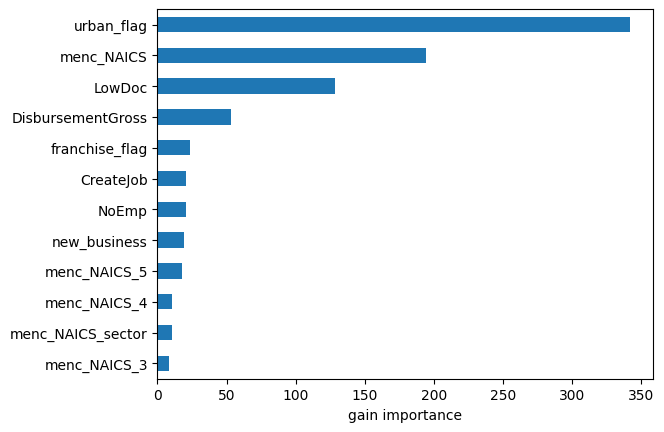

In [46]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A01_PLOT_importance_gain.png'))

##### Permutation Importance

In [47]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [48]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [49]:
perm_importance_df.head(5)

,features,importance,abs_importance
7,menc_NAICS,0.080729,0.080729
3,DisbursementGross,0.067066,0.067066
5,urban_flag,0.035822,0.035822
1,CreateJob,0.018806,0.018806
2,LowDoc,0.014576,0.014576


In [50]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('A01_DATA_importance_perturb.csv'),
            index=False)

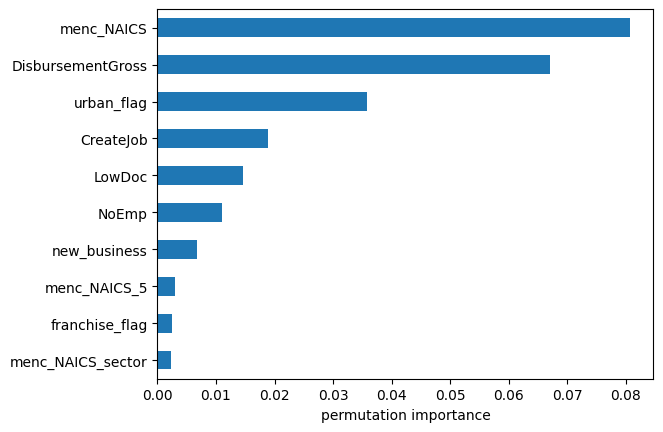

In [51]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('A01_PLOT_importance_perturb.png'))

## PDP Plot - NAICS mean encoded

In [52]:
results = partial_dependence(xgb_model, train_df[predictor_features], ['menc_NAICS'])
pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})

In [53]:
plt.close()

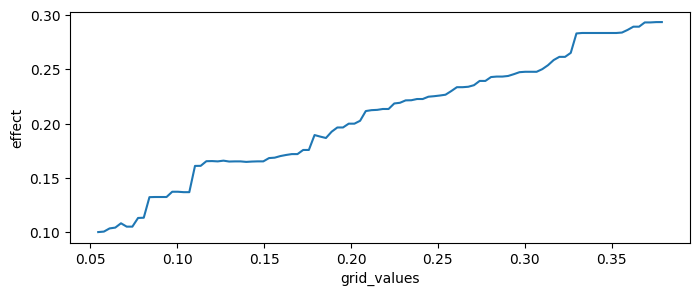

In [54]:
fig, ax = plt.subplots(figsize = (8, 3))
pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax)
ax.set_ylabel('effect')
fig.savefig(Path(setup.temp_path).joinpath('A01_PLOT_pdp_naics_meanenc.png'),
               bbox_inches='tight')